# Libraries

In [253]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression

## Data Prep

In [254]:
df_purchase = pd.read_csv(
    "/home/angelo/repos/vscode_repos/customer_analytics_2022/Data/purchase data.csv"
)

In [255]:
scaler = pickle.load(
    open(
        "/home/angelo/repos/vscode_repos/customer_analytics_2022/pickle_data_models/scaler.pickle",
        "rb",
    )
)

pca = pickle.load(
    open(
        "/home/angelo/repos/vscode_repos/customer_analytics_2022/pickle_data_models/pca_3.pickle",
        "rb",
    )
)

kmeans_pca = pickle.load(
    open(
        "/home/angelo/repos/vscode_repos/customer_analytics_2022/pickle_data_models/kmeans_pca_4.pickle",
        "rb",
    )
)

#### Apply imported models 



In [256]:
# only apply transform; fit would mean that the model is retrained; here we only want to apply it on the data --> so only transform
features = df_purchase.iloc[:, -7:]

# apply the scaler
df_purchase_segm_std = scaler.transform(features)

In [257]:
#### apply the already trained scaler on the new data 
# remember that customers may be duplicates
df_purchase_segm_pca = pca.transform(df_purchase_segm_std)

In [258]:
#### apply the already trained pca_3 (here just pca) on the data 
# now apply the kmeans on it: use the predict method here
purchase_segm_kmeans_pca = kmeans_pca.predict(df_purchase_segm_pca)

In [259]:
#### apply the already trained kmeans model which was trained on the 3 components of the pca model and had k = 4 groups
df_purchase_predictors = df_purchase.copy()
df_purchase_predictors["Segment"] = purchase_segm_kmeans_pca

In [260]:
#### this is now the new dataframe containing the predicted segments for the customers
df_purchase_predictors = df_purchase.copy()
df_purchase_predictors["Segment"] = purchase_segm_kmeans_pca

In [261]:
segment_dummies = pd.get_dummies(purchase_segm_kmeans_pca, 
                                prefix = 'Segment',
                                prefix_sep = '_')

In [262]:
df_purchase_predictors = pd.concat([df_purchase_predictors, segment_dummies], axis = 1)

In [263]:
df_pa = df_purchase_predictors.copy()

In [264]:
df_pa.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
0,200000001,1,0,0,0,0,0,1.59,1.87,2.01,...,47,1,110866,1,0,2,0,0,1,0
1,200000001,11,0,0,0,0,0,1.51,1.89,1.99,...,47,1,110866,1,0,2,0,0,1,0
2,200000001,12,0,0,0,0,0,1.51,1.89,1.99,...,47,1,110866,1,0,2,0,0,1,0
3,200000001,16,0,0,0,0,0,1.52,1.89,1.98,...,47,1,110866,1,0,2,0,0,1,0
4,200000001,18,0,0,0,0,0,1.52,1.89,1.99,...,47,1,110866,1,0,2,0,0,1,0


## Purchase Probability Model

The model task:
dependent: Incidence varaible

independent: Price

We want to know whether a purchase has happened based on the purchase price of a product assuming that purchase probabaility is influenced by price.

In [265]:
Y = df_pa['Incidence']


create price variable irrespective of the brand;

possible choices to consider here:
- i) min and max price which are good indicators how expensive a new product is
- ii) mean or median price


NOTE: the choice here is mean of all prices (while in a store, the customer has the choice to grab 5 different brands... we just average these 5 prices together into one per purchase opportunity in the dataset 8per instance) to see how much of the variance in Incidence can be explained by the average price of all brands together )

We take mean price here as we are only looking for the pruchase probability -- meaning we are lloking for the probability that the customer buys from a CATEGORY and not specific item; so the average price of the category is a good way

In [266]:
# create price variable irrespective of the brand
## mean price is chosen for all prices (Price_1 to Price_5) per row
X = pd.DataFrame()

X['Mean_Price'] = (df_pa['Price_1'] +
                    df_pa['Price_2'] +
                    df_pa['Price_3'] +
                    df_pa['Price_4'] +
                    df_pa['Price_5'] ) / 5



a solver in a models such as LogisticRegression is the technique for the iteration-optimization problem in logisitc regression such as 'sag'

In [267]:
model_purchase = LogisticRegression(solver = 'sag')
model_purchase.fit(X, Y)

LogisticRegression(solver='sag')

by fitting a logistic regression on this data, this command estimates the purchase probabaiility and stores the results in the model_purchase instance of the trained LogisticRegression model.



In [268]:
# coef_ holds the coefficients for a model; here univariate price
model_purchase.coef_

array([[-2.34771593]])

Analysis: negative coefficient indicates that an increase in price will decrease the probabaility of purchase and vice versa

However, logistic regression can do more: this model also quantifies the exact  relationship between pruice and probability of purchase in addition to magnitude (elasiticity)

## Price Elasticity of Purchase Probability

Price elasitiy of purchase probabauility is the percentage change in prucahse probability in response to a one percent change in price in the product category


the coefficient for price here array([[-2.34904564]]) is the change in probabaility given the price; this is what the coefficient shows:

As such we want to see different values for mean price and see how the probabaility 

In [269]:
# create a price range to test
df_pa.loc[:, ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']].describe()

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


minprice is 1.1€; and maxprice is 2.8€

--> expand this range a little got get a better understanding of the elasiticity such as [0.5; 3.5] or even [0 ; 5]

In [270]:
# add a 0.01 price change 
price_range = np.arange(0.5, 3.5, 0.01)

In [271]:
df_price_range = pd.DataFrame(price_range)

In [272]:
# now predict the purchase probabability using the trained model
Y_pr = model_purchase.predict_proba(df_price_range)

/home/angelo/repos/vscode_repos/customer_analytics_2022/lib64/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [273]:
Y_pr

array([[0.08210522, 0.91789478],
       [0.083892  , 0.916108  ],
       [0.08571403, 0.91428597],
       [0.08757185, 0.91242815],
       [0.089466  , 0.910534  ],
       [0.09139701, 0.90860299],
       [0.09336543, 0.90663457],
       [0.0953718 , 0.9046282 ],
       [0.09741665, 0.90258335],
       [0.09950051, 0.90049949],
       [0.10162394, 0.89837606],
       [0.10378746, 0.89621254],
       [0.1059916 , 0.8940084 ],
       [0.1082369 , 0.8917631 ],
       [0.11052389, 0.88947611],
       [0.11285308, 0.88714692],
       [0.115225  , 0.884775  ],
       [0.11764016, 0.88235984],
       [0.12009907, 0.87990093],
       [0.12260223, 0.87739777],
       [0.12515015, 0.87484985],
       [0.12774331, 0.87225669],
       [0.13038219, 0.86961781],
       [0.13306727, 0.86693273],
       [0.13579901, 0.86420099],
       [0.13857787, 0.86142213],
       [0.14140429, 0.85859571],
       [0.1442787 , 0.8557213 ],
       [0.14720152, 0.85279848],
       [0.15017316, 0.84982684],
       [0.

the predicted output above for the different prices shows the class probabilities for 0 & 1 (so unsucessful and successfull); each row == 100%

Probabbility of pruchase (== 1) is the second column

In [274]:
# get only the second column
purchase_pr = Y_pr[:][:, 1]

Question now is:

How is demand for the product change for a given change in price? --> elasiticies will answer this


Definition of price elasiticiy 

E = (delta_Pr(purchase) / (Pr(purchase)) / (delta_Price/Price))

(=) E = beta * price * (1 - Pr(purchase))

In [275]:
# price elastiticity == price coeff of the model
pe = model_purchase.coef_[:, 0] * price_range * (1 - purchase_pr)

#### The above array contains the price elasticity at each price point

In [276]:
df_price_elasticities = pd.DataFrame(price_range)

In [277]:
df_price_elasticities = df_price_elasticities.rename(columns = {0: 'Price_Point'})

In [278]:
df_price_elasticities['Mean_PE'] = pe

each row we have the price point and the price elastitiy of that price point (so a one percent change in price at price point x will increase/decrease the purchase probabaility by xxx%)

Mean_PE is already in percent; eg the first instqance at price point 0.5 --> a price increase of 1% results in a purchase probability decrease of 0.096% 

In [279]:
df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096380
1,0.51,-0.100447
2,0.52,-0.104641
3,0.53,-0.108965
4,0.54,-0.113422
...,...,...
295,3.45,-8.011652
296,3.46,-8.036900
297,3.47,-8.062113
298,3.48,-8.087292


In [280]:
# pd.options.display.max_rows = None
df_price_elasticities

,Price_Point,Mean_PE
0,0.50,-0.096380
1,0.51,-0.100447
2,0.52,-0.104641
3,0.53,-0.108965
4,0.54,-0.113422
...,...,...
295,3.45,-8.011652
296,3.46,-8.036900
297,3.47,-8.062113
298,3.48,-8.087292


## Analyse the elastitiy result

Text(0.5, 1.0, 'Price Elastiticy of Purchase Probabaility')

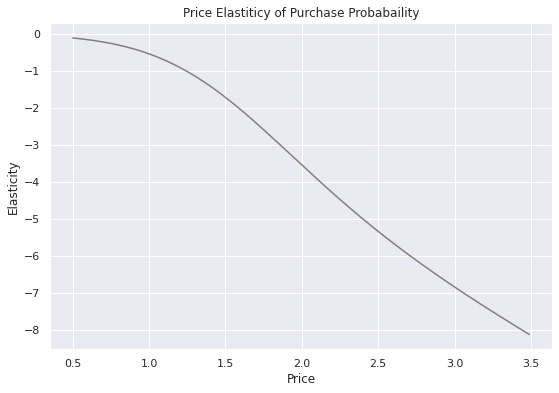

In [281]:
plt.figure(figsize = (9,6))
plt.plot(price_range, pe, color = 'grey')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elastiticy of Purchase Probabaility')

More towards the right, the leass likely it is for people to buy from a category; 

However, this plot of price elasitiyty is very interresting with regards to the rate of decrease --> the decrease in puchase probabauility is leveling off around the 1.1 mark and turning quite steep

Additionally, all price elastiticies are negative: the reason is simple: an increased price will decrease the lieklyhood of buying the product (and coef_ is negative: inverse proportionality of price and purcahse probabuility)

Remember: Price elastiticy measures the percentage change in an outcome (here Purchase probability); example: at price 1.1€ the E = -0.6919 (this is already in percent)--> So for a 1% price increase, the probability of puirchase decreases by 0.69%


|E| < 1 % --> inelastic (y-axis)

|E| >= 1 % --> elastic (y-axis)

is it inelastic or elastic? 
- A change in price by 1% at price point 0.5 leads to LESS then 1% decrease in purchase probabaiulity --> so it is inelastic (all below 1%!!!)
- A price change at 1.5 is MORE than 1% decrease in purchase probabaiulity --> so here it is elastic


recommendation: for inelastic values we should increase the Price ; BUT FOR elastic prices we should decrease our prices!


To do: find those prices that are inelastic and those that are elastic; so find where price elastiticiy turns from elastic to inelastic ---> this is at price point 1.25 ; so at product prices lower that 1.25 we can increase the product price; For prices higher than 1.25 we have more to gain from lower prices



## Purchase Probabaility by Segments

Now proceed to purchase probabaility of category but now of the different segments!

### Segement 1 - Career Focused

In [282]:
# df purchase analytics segment 1 only
df_pa_segment_1 = df_pa[df_pa.Segment == 1]

In [283]:
# now perform the modeling; 
# Estimate the coefficient of price on the purcahse probabaility

# get the Y (incidence)
Y = df_pa_segment_1.Incidence

# create the X (average price)
X = pd.DataFrame()
X['Mean_Price'] = df_pa_segment_1.loc[:,['Price_1', "Price_2", "Price_3", "Price_4", "Price_5"]].mean(axis = 1)


In [284]:
# now perform the model again
# create instance
model_incidence_segment_1 = LogisticRegression(solver='sag')

model_incidence_segment_1.fit(X, Y)

LogisticRegression(solver='sag')

In [285]:
model_incidence_segment_1.coef_

array([[-1.71208415]])

The beta here is lower than the beta of all other segments together; This might suggest a lower elasticity!

In [286]:
# calcualte the elastiticty for the segment

# now predict the purchase probabability using the trained model
Y_pr_segment_1 = model_incidence_segment_1.predict_proba(df_price_range)
# get only the second column
purchase_pr_segment_1 = Y_pr_segment_1[:][:, 1]

# price elastiticity == price coeff of the model
pe_segment_1 = model_incidence_segment_1.coef_[:, 0] * price_range * (1 - purchase_pr_segment_1)

/home/angelo/repos/vscode_repos/customer_analytics_2022/lib64/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [287]:
# put the price elastiticity of segement 1 into a dataframe
df_price_elasticities['PE_Segment_1'] = pe_segment_1
df_price_elasticities


,Price_Point,Mean_PE,PE_Segment_1
0,0.50,-0.096380,-0.119174
1,0.51,-0.100447,-0.123360
2,0.52,-0.104641,-0.127639
3,0.53,-0.108965,-0.132014
4,0.54,-0.113422,-0.136484
...,...,...,...
295,3.45,-8.011652,-5.681673
296,3.46,-8.036900,-5.701829
297,3.47,-8.062113,-5.721948
298,3.48,-8.087292,-5.742030


Text(0.5, 1.0, 'Price Elastiticy of Purchase Probabaility')

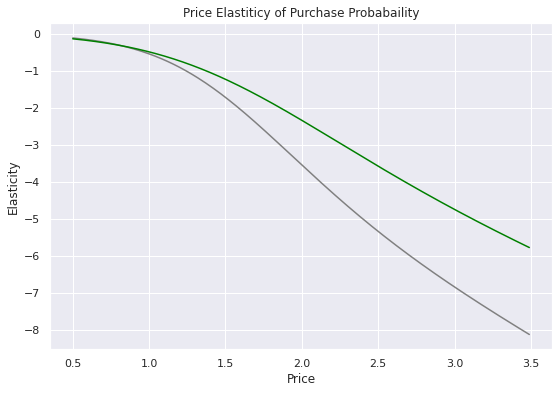

In [288]:
# display both 

plt.figure(figsize = (9,6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elastiticy of Purchase Probabaility')

### interpretation

- In the 0.5 - 1.0 range of price points both elastitictiy curves lie very closely together 
- but then the average for all segments starts having a higher elasticitiy, while the elasticitiy of the first segment (career focused) does not really change after the increase in elastitiy between the pricve points 1.0 and 1.5.

Segement 1 only turns elastic at 1.39€ price point! --> So increase priceses if we are in the 0.5 to 1.39€ price point rrange, while decreasing the price above that price point!

#### Segment 2 Fewer Opportunities




In [289]:
# df purchase analytics segment 1 only
df_pa_segment_2 = df_pa[df_pa.Segment == 2]

# now perform the modeling; 
# Estimate the coefficient of price on the purcahse probabaility

# get the Y (incidence)
Y = df_pa_segment_2.Incidence

# create the X (average price)
X = pd.DataFrame()
X['Mean_Price'] = df_pa_segment_2.loc[:,['Price_1', "Price_2", "Price_3", "Price_4", "Price_5"]].mean(axis = 1)

# now perform the model again
# create instance
model_incidence_segment_2 = LogisticRegression(solver='sag')

model_incidence_segment_2.fit(X, Y)


LogisticRegression(solver='sag')

In [290]:
# calcualte the elastiticty for the segment

# now predict the purchase probabability using the trained model
Y_pr_segment_2 = model_incidence_segment_2.predict_proba(df_price_range)
# get only the second column
purchase_pr_segment_2 = Y_pr_segment_2[:][:, 1]

# price elastiticity == price coeff of the model
pe_segment_2 = model_incidence_segment_2.coef_[:, 0] * price_range * (1 - purchase_pr_segment_2)

/home/angelo/repos/vscode_repos/customer_analytics_2022/lib64/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [291]:
# put the price elastiticity of segement 1 into a dataframe
df_price_elasticities['PE_Segment_2'] = pe_segment_2 
df_price_elasticities


,Price_Point,Mean_PE,PE_Segment_1,PE_Segment_2
0,0.50,-0.096380,-0.119174,-0.030949
1,0.51,-0.100447,-0.123360,-0.032718
2,0.52,-0.104641,-0.127639,-0.034574
3,0.53,-0.108965,-0.132014,-0.036520
4,0.54,-0.113422,-0.136484,-0.038562
...,...,...,...,...
295,3.45,-8.011652,-5.681673,-12.543037
296,3.46,-8.036900,-5.701829,-12.579957
297,3.47,-8.062113,-5.721948,-12.616860
298,3.48,-8.087292,-5.742030,-12.653746


In [292]:
df_price_elasticities[np.abs(df_price_elasticities.PE_Segment_2) > 1]

,Price_Point,Mean_PE,PE_Segment_1,PE_Segment_2
77,1.27,-1.052190,-0.819106,-1.026217
78,1.28,-1.076641,-0.834384,-1.063887
79,1.29,-1.101453,-0.849836,-1.102615
80,1.30,-1.126626,-0.865462,-1.142412
81,1.31,-1.152158,-0.881262,-1.183288
...,...,...,...,...
295,3.45,-8.011652,-5.681673,-12.543037
296,3.46,-8.036900,-5.701829,-12.579957
297,3.47,-8.062113,-5.721948,-12.616860
298,3.48,-8.087292,-5.742030,-12.653746


Text(0.5, 1.0, 'Price Elastiticy of Purchase Probabaility')

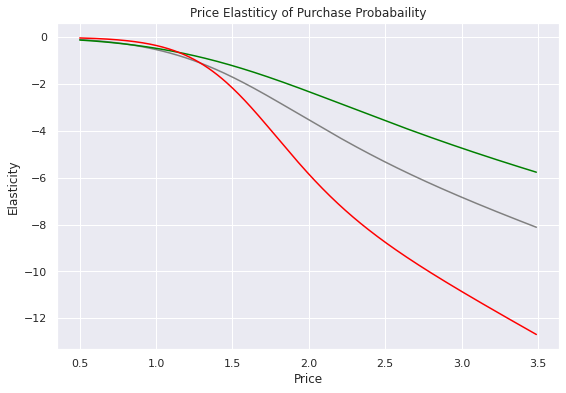

In [293]:
# display both 

plt.figure(figsize = (9,6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.plot(price_range, pe_segment_2, color = 'red')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elastiticy of Purchase Probabaility')

VERY STEEP ELASTITIY compared to career focused! Already at 1.27 it chagnes (however the average of all segments was at 1.27); Increase price before 1.27 and decrease after that! 

So Fewer opportunities is very sensitive to price; an increase in price results in more and more elastiticity!

#### Segment 3 Well off 

In [294]:
# df purchase analytics segment 1 only
df_pa_segment_3 = df_pa[df_pa.Segment == 3]

# now perform the modeling; 
# Estimate the coefficient of price on the purcahse probabaility

# get the Y (incidence)
Y = df_pa_segment_3.Incidence

# create the X (average price)
X = pd.DataFrame()
X['Mean_Price'] = df_pa_segment_3.loc[:,['Price_1', "Price_2", "Price_3", "Price_4", "Price_5"]].mean(axis = 1)

# now perform the model again
# create instance
model_incidence_segment_3 = LogisticRegression(solver='sag')

model_incidence_segment_3.fit(X, Y)


LogisticRegression(solver='sag')

In [295]:
# calcualte the elastiticty for the segment

# now predict the purchase probabability using the trained model
Y_pr_segment_3 = model_incidence_segment_3.predict_proba(df_price_range)
# get only the second column
purchase_pr_segment_3 = Y_pr_segment_3[:][:, 1]

# price elastiticity == price coeff of the model
pe_segment_3 = model_incidence_segment_3.coef_[:, 0] * price_range * (1 - purchase_pr_segment_3)

/home/angelo/repos/vscode_repos/customer_analytics_2022/lib64/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [296]:
# put the price elastiticity of segement 1 into a dataframe
df_price_elasticities['PE_Segment_3'] = pe_segment_3 
df_price_elasticities


,Price_Point,Mean_PE,PE_Segment_1,PE_Segment_2,PE_Segment_3
0,0.50,-0.096380,-0.119174,-0.030949,-0.168112
1,0.51,-0.100447,-0.123360,-0.032718,-0.173041
2,0.52,-0.104641,-0.127639,-0.034574,-0.178039
3,0.53,-0.108965,-0.132014,-0.036520,-0.183109
4,0.54,-0.113422,-0.136484,-0.038562,-0.188250
...,...,...,...,...,...
295,3.45,-8.011652,-5.681673,-12.543037,-4.025773
296,3.46,-8.036900,-5.701829,-12.579957,-4.040649
297,3.47,-8.062113,-5.721948,-12.616860,-4.055509
298,3.48,-8.087292,-5.742030,-12.653746,-4.070353


Text(0.5, 1.0, 'Price Elastiticy of Purchase Probabaility')

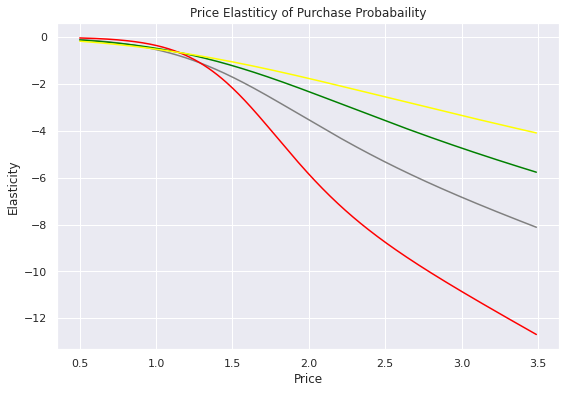

In [297]:
# display both 

plt.figure(figsize = (9,6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.plot(price_range, pe_segment_2, color = 'red')
plt.plot(price_range, pe_segment_3, color = 'yellow')
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elastiticy of Purchase Probabaility')

#### Segment 0 Standard 

In [298]:
# df purchase analytics segment 1 only
df_pa_segment_0 = df_pa[df_pa.Segment == 0]

# now perform the modeling; 
# Estimate the coefficient of price on the purcahse probabaility

# get the Y (incidence)
Y = df_pa_segment_0.Incidence

# create the X (average price)
X = pd.DataFrame()
X['Mean_Price'] = df_pa_segment_0.loc[:,['Price_1', "Price_2", "Price_3", "Price_4", "Price_5"]].mean(axis = 1)

# now perform the model again
# create instance
model_incidence_segment_0 = LogisticRegression(solver='sag')

model_incidence_segment_0.fit(X, Y)


LogisticRegression(solver='sag')

In [299]:
# calcualte the elastiticty for the segment

# now predict the purchase probabability using the trained model
Y_pr_segment_0 = model_incidence_segment_0.predict_proba(df_price_range)
# get only the second column
purchase_pr_segment_0 = Y_pr_segment_0[:][:, 1]

# price elastiticity == price coeff of the model
pe_segment_0 = model_incidence_segment_0.coef_[:, 0] * price_range * (1 - purchase_pr_segment_0)

/home/angelo/repos/vscode_repos/customer_analytics_2022/lib64/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [300]:
# put the price elastiticity of segement 1 into a dataframe
df_price_elasticities['PE_Segment_0'] = pe_segment_0 
df_price_elasticities


,Price_Point,Mean_PE,PE_Segment_1,PE_Segment_2,PE_Segment_3,PE_Segment_0
0,0.50,-0.096380,-0.119174,-0.030949,-0.168112,-0.211271
1,0.51,-0.100447,-0.123360,-0.032718,-0.173041,-0.217845
2,0.52,-0.104641,-0.127639,-0.034574,-0.178039,-0.224526
3,0.53,-0.108965,-0.132014,-0.036520,-0.183109,-0.231316
4,0.54,-0.113422,-0.136484,-0.038562,-0.188250,-0.238215
...,...,...,...,...,...,...
295,3.45,-8.011652,-5.681673,-12.543037,-4.025773,-5.052922
296,3.46,-8.036900,-5.701829,-12.579957,-4.040649,-5.069780
297,3.47,-8.062113,-5.721948,-12.616860,-4.055509,-5.086619
298,3.48,-8.087292,-5.742030,-12.653746,-4.070353,-5.103440


Text(0.5, 1.0, 'Price Elastiticy of Purchase Probabaility')

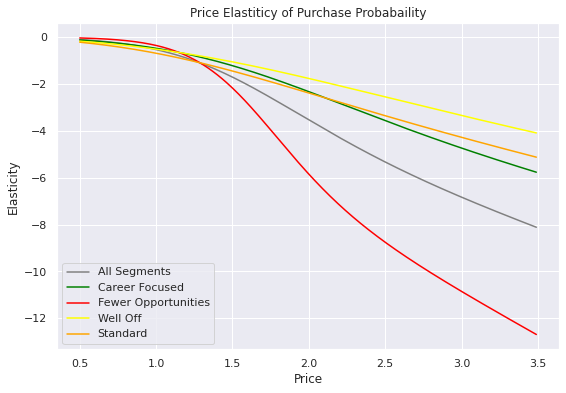

In [301]:
# display both 

plt.figure(figsize = (9,6))
plt.plot(price_range, pe, color = 'grey')
plt.plot(price_range, pe_segment_1, color = 'green')
plt.plot(price_range, pe_segment_2, color = 'red')
plt.plot(price_range, pe_segment_3, color = 'yellow')
plt.plot(price_range, pe_segment_0, color = 'orange')
plt.legend(['All Segments', 'Career Focused', 'Fewer Opportunities', 'Well Off', 'Standard'])
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price Elastiticy of Purchase Probabaility')

## purchase Probabaulity with Promotion Feature

#### Extend the Purchase probabaility model using a multivariate model

#### data preparation

Do the purchase probabaility using average prie and promotion for all segments together again

In [302]:
# Incidence column whether a purchase in a specific category has taken place. 
Y = df_pa.Incidence

In [303]:
# X is now price and promotion
X = pd.DataFrame()
X['Mean_Price'] = df_pa.loc[:,['Price_1','Price_2', 'Price_3', 'Price_4', 'Price_5']].mean(axis = 1)

In [304]:
# add promotion as a feature
X['Mean_Promotion'] = df_pa.loc[:,['Promotion_1',
                                    'Promotion_2', 
                                    'Promotion_3', 
                                    'Promotion_4', 
                                    'Promotion_5']].mean(axis = 1)

In [305]:
# Init the model
model_incidence_promotion = LogisticRegression(solver='sag')
model_incidence_promotion.fit(X, Y)

LogisticRegression(solver='sag')

In [306]:
model_incidence_promotion.coef_

array([[-1.49400638,  0.56152461]])

result: price coef is not not as strong anymore; Positive coef for promotion (logical!)

--> The model quantifies the exact relationship between price, promotion and probability of purchase using logreg on incidence

### Price elastiticity with Promotion

In [307]:
df_price_elastiticty_promotion = pd.DataFrame(price_range)
df_price_elastiticty_promotion = df_price_elastiticty_promotion.rename({0 : 'Price_Range'}, axis = 1)

In [308]:
df_price_elastiticty_promotion.head()

,Price_Range
0,0.50
1,0.51
2,0.52
3,0.53
4,0.54


Note: in order to predict in our model we need data as the second feature in our model (here we so far only have price range); so we need instances of corresponding values for promotion for the different price points

We are interested in the overall effect  of promotion on elastiticies! as such explore two cases

case 1: promotional activities for all brands
case 2: no promotional activities

In [309]:
# case 1: promotion activities for all brands on
df_price_elastiticty_promotion['Promotion'] = 1



In [310]:
Y_pr_promotion = model_incidence_promotion.predict_proba(df_price_elastiticty_promotion)

/home/angelo/repos/vscode_repos/customer_analytics_2022/lib64/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Price_Range
- Promotion
Feature names seen at fit time, yet now missing:
- Mean_Price
- Mean_Promotion

  warnings.warn(message, FutureWarning)


In [311]:
promo_pr = Y_pr_promotion[: , 1]
price_elasticity_promo = (model_incidence_promotion.coef_[:, 0] * price_range) * (1 - promo_pr)

In [312]:
# add this promotion elastitiy to the overall df with elastiticites
df_price_elasticities['Elasticity_Promotion_1'] = price_elasticity_promo


In [313]:
df_price_elasticities.head()

,Price_Point,Mean_PE,PE_Segment_1,PE_Segment_2,PE_Segment_3,PE_Segment_0,Elasticity_Promotion_1
0,0.50,-0.096380,-0.119174,-0.030949,-0.168112,-0.211271,-0.125737
1,0.51,-0.100447,-0.123360,-0.032718,-0.173041,-0.217845,-0.129854
2,0.52,-0.104641,-0.127639,-0.034574,-0.178039,-0.224526,-0.134049
3,0.53,-0.108965,-0.132014,-0.036520,-0.183109,-0.231316,-0.138324
4,0.54,-0.113422,-0.136484,-0.038562,-0.188250,-0.238215,-0.142680


### case 2: price elastitiy for no promotion

In [314]:
# case 2: promotion activities for all brands turned off
df_price_elastiticty_promotion['Promotion'] = 0

In [315]:
# predict 
Y_pr_promotion = model_incidence_promotion.predict_proba(df_price_elastiticty_promotion)

/home/angelo/repos/vscode_repos/customer_analytics_2022/lib64/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Price_Range
- Promotion
Feature names seen at fit time, yet now missing:
- Mean_Price
- Mean_Promotion

  warnings.warn(message, FutureWarning)


In [316]:
promo_pr = Y_pr_promotion[: , 1]
price_elasticity_promo = (model_incidence_promotion.coef_[:, 0] * price_range) * (1 - promo_pr)

In [317]:
# add this promotion elastitiy to the overall df with elastiticites
df_price_elasticities['Elasticity_Promotion_0'] = price_elasticity_promo


In [319]:
df_price_elasticities.head()

,Price_Point,Mean_PE,PE_Segment_1,PE_Segment_2,PE_Segment_3,PE_Segment_0,Elasticity_Promotion_1,Elasticity_Promotion_0
0,0.50,-0.096380,-0.119174,-0.030949,-0.168112,-0.211271,-0.125737,-0.195651
1,0.51,-0.100447,-0.123360,-0.032718,-0.173041,-0.217845,-0.129854,-0.201773
2,0.52,-0.104641,-0.127639,-0.034574,-0.178039,-0.224526,-0.134049,-0.207997
3,0.53,-0.108965,-0.132014,-0.036520,-0.183109,-0.231316,-0.138324,-0.214324
4,0.54,-0.113422,-0.136484,-0.038562,-0.188250,-0.238215,-0.142680,-0.220755


#### Price elastiticy of purchase probability with and without promotion

Show the elasticity for both elasticity curves of active vs non activve promotion 


--> Showing purchase probability elastictiy given maximum and minimum promotional activity

Text(0.5, 1.0, 'Price elastiticy of purchase probability with and without promotion')

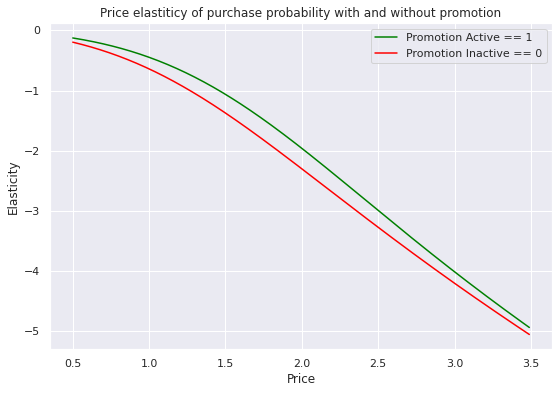

In [323]:
# display both 

plt.figure(figsize = (9,6))
plt.plot(price_range, df_price_elasticities.Elasticity_Promotion_1, color = 'green')
plt.plot(price_range, df_price_elasticities.Elasticity_Promotion_0, color = 'red')
plt.legend(['Promotion Active == 1', 'Promotion Inactive == 0'])
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Price elastiticy of purchase probability with and without promotion')

graph shows that the elasttictiy curve of promotion == 1 sits above the elastictiy curve of no promotion; this means that promotion reduces the elasticity in general of all segments, thereby showing potential that higher price + promotion is a good pricign strategy. However this must be analyzed in the segments themselfes to differentiate betweeen the different custoemrs

Also:

the Promotion curve turns from inelastic to elastic at 1.45€ (so elastictiy above 1); the non promotion curve already turns at 1.27€ elastic!

So people are more willing to buy products at promotional prices; irrespective of the price (at least a little)--> customers are less price senstive to price changes when there are promotion activitites conducted; so have a higher original price + promotion

--> examine for the segments themselfes

## Proceed to brand Purchase probabaility 


#### now only shopping occasions that succeed (so incident == 1 and/or brand_variable != 0)

In [332]:
df_pa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58693 entries, 0 to 58692
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 58693 non-null  int64  
 1   Day                58693 non-null  int64  
 2   Incidence          58693 non-null  int64  
 3   Brand              58693 non-null  int64  
 4   Quantity           58693 non-null  int64  
 5   Last_Inc_Brand     58693 non-null  int64  
 6   Last_Inc_Quantity  58693 non-null  int64  
 7   Price_1            58693 non-null  float64
 8   Price_2            58693 non-null  float64
 9   Price_3            58693 non-null  float64
 10  Price_4            58693 non-null  float64
 11  Price_5            58693 non-null  float64
 12  Promotion_1        58693 non-null  int64  
 13  Promotion_2        58693 non-null  int64  
 14  Promotion_3        58693 non-null  int64  
 15  Promotion_4        58693 non-null  int64  
 16  Promotion_5        586

In [337]:
brand_choice = df_pa[df_pa.Incidence == 1]

In [338]:
brand_choice.head()

,ID,Day,Incidence,Brand,Quantity,Last_Inc_Brand,Last_Inc_Quantity,Price_1,Price_2,Price_3,...,Age,Education,Income,Occupation,Settlement size,Segment,Segment_0,Segment_1,Segment_2,Segment_3
6,200000001,28,1,2,2,0,0,1.50,1.90,1.99,...,47,1,110866,1,0,2,0,0,1,0
11,200000001,58,1,5,1,0,0,1.39,1.90,1.91,...,47,1,110866,1,0,2,0,0,1,0
19,200000001,110,1,1,2,0,0,1.47,1.90,1.99,...,47,1,110866,1,0,2,0,0,1,0
24,200000001,142,1,4,1,0,0,1.21,1.35,1.99,...,47,1,110866,1,0,2,0,0,1,0
29,200000001,183,1,2,3,0,0,1.46,1.88,1.97,...,47,1,110866,1,0,2,0,0,1,0


the new model will proedict the branch choice of a customer given that the customer will buy one of the different brands

In [347]:
# define outcome 
Y = brand_choice.Brand

get all brand prices: we want to knwo what 1) happens if we chagne the price of our brand and 2 ) what happens if the competitor changes their price wrt. purchase probability. 

In [348]:
# select the price of the brand value in the corresponding row

brand_choice.columns

Index(['ID', 'Day', 'Incidence', 'Brand', 'Quantity', 'Last_Inc_Brand',
       'Last_Inc_Quantity', 'Price_1', 'Price_2', 'Price_3', 'Price_4',
       'Price_5', 'Promotion_1', 'Promotion_2', 'Promotion_3', 'Promotion_4',
       'Promotion_5', 'Sex', 'Marital status', 'Age', 'Education', 'Income',
       'Occupation', 'Settlement size', 'Segment', 'Segment_0', 'Segment_1',
       'Segment_2', 'Segment_3'],
      dtype='object')

In [349]:
features = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
X = brand_choice[features]

In [351]:
model_brand_choice = LogisticRegression(solver = 'sag', multi_class = 'multinomial')
model_brand_choice.fit(X, Y)

LogisticRegression(multi_class='multinomial', solver='sag')

In [352]:
# 5 x 5 because 5 outcome classes and 5features (5 different prices)
model_brand_choice.coef_

array([[-3.91597507,  0.65845011,  2.41765329,  0.70406924, -0.20213237],
       [ 1.27460379, -1.87985961, -0.21267551, -0.20634783,  0.58786147],
       [ 1.62423408,  0.56213421,  0.50104809,  1.03954518,  0.45283978],
       [ 0.57452627,  0.39558174, -1.40064543, -1.24625194,  0.249339  ],
       [ 0.44261094,  0.26369355, -1.30538044, -0.29101464, -1.08790788]])

Problem is that we do not see which coefficient relates to which outcome class!
So better put it into a dataframe

In [353]:
bc_coef = pd.DataFrame(model_brand_choice.coef_)

In [354]:
# transpose it
bc_coef = pd.DataFrame(model_brand_choice.coef_.T)

In [358]:
coeffieicnt_names = ['Coef_Brand_1', 'Coef_Brand_2', 'Coef_Brand_3', 'Coef_Brand_4', 'Coef_Brand_5']
bc_coef.columns = [coeffieicnt_names]


# adjust the prices in the rows
prices_names = ['Price_1', 'Price_2', 'Price_3', 'Price_4', 'Price_5']
bc_coef.index = [prices_names]

#round all coef
bc_coef = bc_coef.round(3)

In [359]:
bc_coef

,Coef_Brand_1,Coef_Brand_2,Coef_Brand_3,Coef_Brand_4,Coef_Brand_5
Price_1,-3.916,1.275,1.624,0.575,0.443
Price_2,0.658,-1.880,0.562,0.396,0.264
Price_3,2.418,-0.213,0.501,-1.401,-1.305
Price_4,0.704,-0.206,1.040,-1.246,-0.291
Price_5,-0.202,0.588,0.453,0.249,-1.088


Analysis:
1. Coef_brand_1 is negative (strong) with price_1 and positive with all other prices (except 5)

--> we know already: the higher the price of a product the lower the probability of it being purchased (given the negative trend in the elasticities)
--> But it is positive with all others simply because if the other brands (competitors) increase their price, the probability of our brand being puchased increases (price and brand coef are in the correspondign diagonal)

This logreg just represents the choice probability of the brand in question (brand 1- 5 ) with respect to its own priice in addition to other brands price as well; these are OWN brand effects and corss brand effects




## Own Price Elastiticy -- here Own price elasticity brand 5

#### Diagonal dispalys the own price elasticity --> What happens if I increase the price for my own product brand 5? (effects of price chagnes to your own brand)

#### column wise is cross brand effects --> What happens to other brands change their price

In [362]:
# brand 5 is the most expensive
df_own_brand_5 = pd.DataFrame(index = np.arange(price_range.size))

df_own_brand_5['Price_1'] = brand_choice['Price_1'].mean()
df_own_brand_5['Price_2'] = brand_choice['Price_2'].mean()
df_own_brand_5['Price_3'] = brand_choice['Price_3'].mean()
df_own_brand_5['Price_4'] = brand_choice['Price_4'].mean()

# now for our brand we use the price range --> so for different price points what happens?
df_own_brand_5['Price_5'] = price_range
df_own_brand_5

,Price_1,Price_2,Price_3,Price_4,Price_5
0,1.384559,1.764717,2.006694,2.159658,0.50
1,1.384559,1.764717,2.006694,2.159658,0.51
2,1.384559,1.764717,2.006694,2.159658,0.52
3,1.384559,1.764717,2.006694,2.159658,0.53
4,1.384559,1.764717,2.006694,2.159658,0.54
...,...,...,...,...,...
295,1.384559,1.764717,2.006694,2.159658,3.45
296,1.384559,1.764717,2.006694,2.159658,3.46
297,1.384559,1.764717,2.006694,2.159658,3.47
298,1.384559,1.764717,2.006694,2.159658,3.48


Essentially we  will be predicting the purchase probability of brand 5 for different price points 

In [374]:
predict_brand_5 = model_brand_choice.predict_proba(df_own_brand_5)

In [375]:
predict_brand_5

array([[0.03290802, 0.02177652, 0.00543755, 0.02988827, 0.90998964],
       [0.03316275, 0.02211913, 0.00551565, 0.03025592, 0.90894655],
       [0.03341898, 0.02246682, 0.00559479, 0.03062765, 0.90789177],
       ...,
       [0.06881308, 0.47570187, 0.07954102, 0.23889246, 0.13705157],
       [0.06852746, 0.47748464, 0.07973139, 0.23897738, 0.13527913],
       [0.06824089, 0.4792591 , 0.07991971, 0.23905486, 0.13352543]])

In [376]:
pr_own_brand_5 = predict_brand_5[: ][:, 4]

E = ß * price   * (1 - Pr(Purchase Probability))

In this case we are interested in the price coefficient of brand 5 (so tha last row of bc_coef); additionally our dependent varaible of the multivariable regression model is Brand 5

So the right coefficeint == ß is in this case: -1.088

In [382]:
# now calcualte the purchase elasticity 
beta5 = bc_coef.iloc[-1, -1]

In [384]:
own_price_elastiticty_brand_5 = beta5 * price_range * (1 - pr_own_brand_5)

In [387]:
# add it to the overall elasticities dataframe

df_price_elasticities['Brand_5'] = own_price_elastiticty_brand_5

In [388]:
df_price_elasticities

,Price_Point,Mean_PE,PE_Segment_1,PE_Segment_2,PE_Segment_3,PE_Segment_0,Elasticity_Promotion_1,Elasticity_Promotion_0,Brand_5
0,0.50,-0.096380,-0.119174,-0.030949,-0.168112,-0.211271,-0.125737,-0.195651,-0.048966
1,0.51,-0.100447,-0.123360,-0.032718,-0.173041,-0.217845,-0.129854,-0.201773,-0.050524
2,0.52,-0.104641,-0.127639,-0.034574,-0.178039,-0.224526,-0.134049,-0.207997,-0.052111
3,0.53,-0.108965,-0.132014,-0.036520,-0.183109,-0.231316,-0.138324,-0.214324,-0.053728
4,0.54,-0.113422,-0.136484,-0.038562,-0.188250,-0.238215,-0.142680,-0.220755,-0.055376
...,...,...,...,...,...,...,...,...,...
295,3.45,-8.011652,-5.681673,-12.543037,-4.025773,-5.052922,-4.861560,-4.983172,-3.225645
296,3.46,-8.036900,-5.701829,-12.579957,-4.040649,-5.069780,-4.879762,-5.000078,-3.241809
297,3.47,-8.062113,-5.721948,-12.616860,-4.055509,-5.086619,-4.897933,-5.016964,-3.257941
298,3.48,-8.087292,-5.742030,-12.653746,-4.070353,-5.103440,-4.916073,-5.033830,-3.274041


Text(0.5, 1.0, 'Own Price elasticity of Purchase Porbability for brand 5')

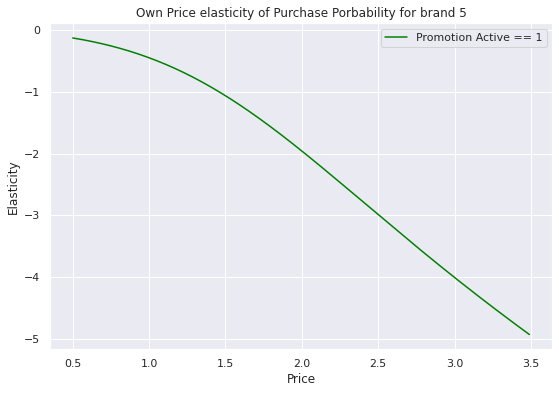

In [389]:
# display both 
plt.figure(figsize = (9,6))
plt.plot(price_range, df_price_elasticities.Elasticity_Promotion_1, color = 'green')
plt.legend(['Promotion Active == 1', 'Promotion Inactive == 0'])
plt.xlabel('Price')
plt.ylabel('Elasticity')
plt.title('Own Price elasticity of Purchase Porbability for brand 5')

But what happens to the purchase probability of brand 5 if a competitor chagned their pricing?

--> Cross price elasticities